<a href="https://colab.research.google.com/github/Patatone/Analysis-of-the-COVID-19-impact-on-LTE-Networks/blob/main/Analysis_of_the_COVID_19_impact_on_LTE_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 !pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 15.9 MB/s 
     |████████████████████████████████| 16.7 MB 244 kB/s 
     |████████████████████████████████| 6.3 MB 50.6 MB/s 


In [2]:
import numpy as np
import pandas as pd
import geopandas
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import datetime
from sklearn.cluster import KMeans

# Import Data


In [3]:
from google.colab import drive
import glob
import os

# Use this Section to import the data files provided in the project folder.

# NETWORK KPI
# Location: Milan ; Reference month: either January, February or March 2020:

## Google drive required lines
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab Notebooks/MRN_data/'

## Local path required lines
# file_path = ''

# KPIs
# We select January, February and March
all_files = glob.glob(os.path.join(file_path , "Milano_800*.csv"))
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

data = pd.concat(li, axis=0, ignore_index=True)

data.drop(['Unnamed: 0'], axis=1, inplace=True)
data['Date'] = pd.to_datetime(data['Date'])

# Cells Location:
locations = pd.read_csv(file_path+'Coordinates_MILANO.csv')

# https://pandas.pydata.org

# This section shows some information regarding the dataset
print(20*'*')
print('Data types:\n')
print(data.dtypes)
print(20*'*')  
print('Number of data points: ', len(data))
print('Number of columns in the dataset: ', len(data.columns))
print(20*'*')
print(data.isnull().sum(axis=0)) # this command show the number of NON valid data points for each column of the dataset:
                                 # a KPI measure for some timestamp can get lost during the storing procedure
print(20*'*')


Mounted at /content/drive
********************
Data types:

REGIONE                    object
COMUNE                     object
Date               datetime64[ns]
ECELL_ID                   object
DL_BW                     float64
RRC_S_SR                  float64
RRC_RE_SR                 float64
ERAB_S_SR                 float64
CS_SR                     float64
IntraF_Hout_SR            float64
InterF_Hout_SR            float64
Hin_SR                    float64
DL_VOL                    float64
UL_VOL                    float64
DL_THR_AVG                float64
UL_THR_AVG                float64
DL_THR_MAX                float64
UL_THR_MAX                float64
USERNUM_MAX               float64
PRB_DL_Used_Avg           float64
PRB_UL_Used_Avg           float64
dtype: object
********************
Number of data points:  841085
Number of columns in the dataset:  21
********************
REGIONE                0
COMUNE                 0
Date                   0
ECELL_ID               0
D

In [4]:
# Here you can understand the size of the scenario, 
# i.e., how many cells you are considering.
print('Number of (distinct) cells: ', len(data.drop_duplicates(subset='ECELL_ID')))


Number of (distinct) cells:  398


# Data Pre-Processing

In [5]:
# We can split the dataset into tree perdios:
# Full lockdown -> from "9th March 2020" to "31th March 2020"(last data)
# Restrictions -> from "16th February 2020" to "9th March 2020"
# Covid free - > from "1 January 2020"(first data) to "16th February 2020"

full_lockdown_end_date = pd.Timestamp(year=2020, month=4, day=1, hour = 0, minute =1)
full_lockdown_start_date = pd.Timestamp(year=2020, month=3, day=8, hour = 23, minute =59)

restrictions_end_date = pd.Timestamp(year=2020, month=3, day=10, hour = 0, minute =1)
restrictions_start_date = pd.Timestamp(year=2020, month=2, day=15, hour = 23, minute =59)

covid_free_end_date = pd.Timestamp(year=2020, month=2, day=17, hour = 0, minute =1)
covid_free_start_date = pd.Timestamp(year=2019, month=12, day=12, hour = 23, minute =59)


full_lockdown = data[data['Date'] < full_lockdown_end_date]
full_lockdown = full_lockdown[full_lockdown['Date'] > full_lockdown_start_date]

restrictions = data[data['Date'] < restrictions_end_date]
restrictions = restrictions[restrictions['Date'] > restrictions_start_date]

covid_free = data[data['Date'] < covid_free_end_date]
covid_free = covid_free[covid_free['Date'] > covid_free_start_date]

periods_lables = ['Covid Free','Restrictions','Full Lockdown']
periods_data = [covid_free, restrictions, full_lockdown]
for i in range(0, 3):
  print('Number of', periods_lables[i], 'data points:', len(periods_data[i]))


Number of Covid Free data points: 434975
Number of Restrictions data points: 217267
Number of Full Lockdown data points: 208081


In [6]:
# Typically, daily and night KPIs traces are analysed differently, as network users 
# show very different behaviours depending on the two moments. 
#In this section, the considered weekly data are grouped into Daily (from 6AM to 24 PM) 
# and Night (from 00 AM to 6 AM) Data

# January
#week_day = week.set_index('Date').between_time('06:00:00', '23:59:59')
#week_night = week.set_index('Date').between_time('00:00:00', '05:59:59')


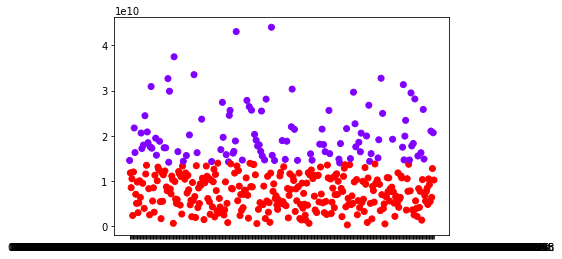

,ENODEB_ID,ECELL_ID,LONG_X,LAT_Y
0,930b285c764e554f338f671864b30d3941935b00,b7de6cd46e855aaec8e28b26d1767e7a738819db,9.208433,45.445358
36,6c6e77c44a598b0e34a0ff19832137cc24a31db7,6807ba8768ea1c61b922795a02dd6e8c1f5823e1,9.214511,45.469421
42,20dc89dfa2970fba49975c8021d729dbb93d9c86,5a6ea208eb7b2dcbf59dc457706b8b04a5a8e1b2,9.193417,45.444824
44,20dc89dfa2970fba49975c8021d729dbb93d9c86,b7eed02edd74696bf65d055085787772478961de,9.193417,45.444824
63,40f32a1f1aa8eda96c790da1d0209c956c2d5b21,990da217a32dfbeea658a704a2973a5280916cf1,9.214499,45.410362
...,...,...,...,...
839,ab04b1426f611328630c95d3cfe2c149d436ef22,a38fbed0769f520276da7396e141d9871e07ba41,9.190575,45.457203
849,f1928cd6202628a7c379a4846195d266d9129a98,e3465afcad2e8b1c1f754b093d38f47b410fd373,9.097222,45.520443
856,391bbd0e2b43f9b0e03043fbe87999bf3910ebf1,203ee6db932bd6d2c474b080946d68ccb1f44536,9.111279,45.472778
924,0c37e6369bb6f6804dd9a9520f9f09e09e659dac,8046d7bbe220531f778ba266f2ce27e834146125,9.214778,45.475750


,ENODEB_ID,ECELL_ID,LONG_X,LAT_Y
1,930b285c764e554f338f671864b30d3941935b00,3821116bcdc789c9d54369ddd58b8e75fafdcb59,9.208433,45.445358
2,930b285c764e554f338f671864b30d3941935b00,9ed9d0f30e21c0218c987496c433e11dd611c9d2,9.208433,45.445358
12,b1184e88a14997cf01299b13908568d949a1be53,cdff26a5c4ce73ee8aef8684045e74727f395bf5,9.227019,45.463230
13,b1184e88a14997cf01299b13908568d949a1be53,01e15165b5683c9f4922e7ffdc82471e479e7779,9.227019,45.463230
14,b1184e88a14997cf01299b13908568d949a1be53,7acc6c5a9eaca072979d30109d52e4375cdc11f7,9.227019,45.463230
...,...,...,...,...
950,f161d41795890db558d3e34b6ddd61bda77e8764,dfee8b67dd0f806325484e2fd32e1bdcb93bd491,9.175056,45.460056
951,f161d41795890db558d3e34b6ddd61bda77e8764,963d7b7a00e2b9c7d20fe313dced0388be5b4dac,9.175056,45.460056
955,3fdbc872d547a3c5b6404cb90960ed717085fa0b,8c203d8b0fb924503c6af744f2035aa43867d1fb,9.158972,45.505527
956,3fdbc872d547a3c5b6404cb90960ed717085fa0b,82a9f5269531147ac5ce15ff92fd8172d1ff0bcf,9.158972,45.505527


In [7]:
# CLUSTERING PART 

#creating dataset with relevant data from previous DataFrame
x = covid_free[['ECELL_ID', 'DL_VOL']]
x = x.groupby(['ECELL_ID']).sum()
x = x.reset_index()
x = x.rename(columns={"index": "ECELL_ID", 0 : "DL_VOL"})

# selecting the DL_Volume column as entry data for the k-means clustering algorithm
dl_array = x['DL_VOL'].to_numpy().reshape(-1, 1)
#creating a 2 clusters k-means value clustering class and fitting the DataFrame accordingly
kmeans = KMeans(n_clusters=2, random_state=0).fit(dl_array)
identified_clusters = kmeans.fit_predict(dl_array)
data_with_clusters = x.copy()
data_with_clusters['Clusters'] = identified_clusters
#scattering the plot
plt.scatter(data_with_clusters['ECELL_ID'], data_with_clusters['DL_VOL'], c=data_with_clusters['Clusters'],
            cmap='rainbow')
plt.show()

print()

#splitting residential cells from non-residential ones
support_business = data_with_clusters.drop(data_with_clusters[data_with_clusters.Clusters < 1].index)
support_residential = data_with_clusters.drop(data_with_clusters[data_with_clusters.Clusters > 0].index)

# Splitting all the data according to the clusters
residential_data = data.loc[data['ECELL_ID'].isin(support_residential['ECELL_ID'])]
business_data = data.loc[data['ECELL_ID'].isin(support_business['ECELL_ID'])]

# Splitting all the locations according to the clusters
residential_locations = locations.loc[locations['ECELL_ID'].isin(support_residential['ECELL_ID'])]
business_locations = locations.loc[locations['ECELL_ID'].isin(support_business['ECELL_ID'])]

display(residential_locations)
display(business_locations)


In [8]:
# We can split the CLUSTERED dataset into tree perdios:
# Full lockdown -> from "9th March 2020" to "31th March 2020"(last data)
# Restrictions -> from "16th February 2020" to "9th March 2020"
# Covid free - > from "1 January 2020"(first data) to "16th February 2020"

full_lockdown_residential = residential_data[residential_data['Date'] < full_lockdown_end_date]
full_lockdown_residential = full_lockdown_residential[full_lockdown_residential['Date'] > full_lockdown_start_date]

full_lockdown_business = business_data[business_data['Date'] < full_lockdown_end_date]
full_lockdown_business = full_lockdown_business[full_lockdown_business['Date'] > full_lockdown_start_date]

restrictions_residential = residential_data[residential_data['Date'] < restrictions_end_date]
restrictions_residential = restrictions_residential[restrictions_residential['Date'] > restrictions_start_date]

restrictions_business = business_data[business_data['Date'] < restrictions_end_date]
restrictions_business = restrictions_business[restrictions_business['Date'] > restrictions_start_date]

covid_free_residential = residential_data[residential_data['Date'] < covid_free_end_date]
covid_free_residential = covid_free_residential[covid_free_residential['Date'] > covid_free_start_date]

covid_free_business = business_data[business_data['Date'] < covid_free_end_date]
covid_free_business = covid_free_business[covid_free_business['Date'] > covid_free_start_date]

periods_lables = ['Covid Free','Restrictions','Full Lockdown']
periods_data = [covid_free, restrictions, full_lockdown]
for i in range(0, 3):
  print('Number of', periods_lables[i], 'data points:', len(periods_data[i]))


Number of Covid Free data points: 434975
Number of Restrictions data points: 217267
Number of Full Lockdown data points: 208081


# Data Visualization

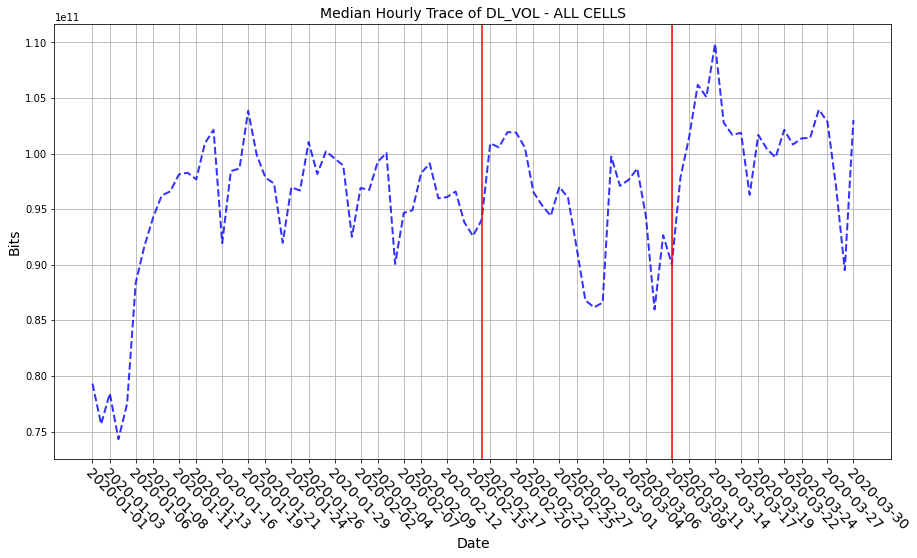

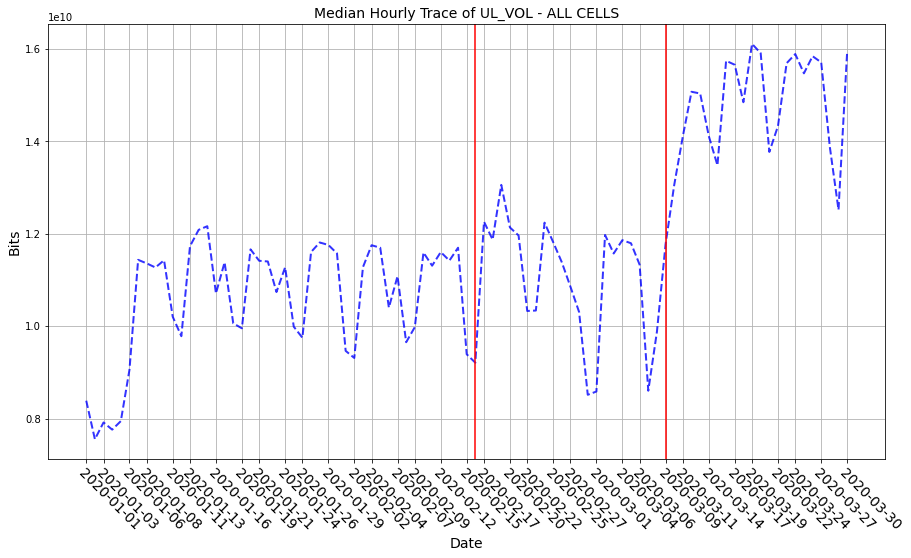

In [9]:
# This section plots the Traffic Downloaded from the ALL cells in a month

def periods_trace_plot_daily(ref_KPI, operation, ylabel):
  # Create a copy of the original dataset
  data_temp = data.copy()

  # Set Daily granularity instead of Hourly granularity
  data_temp['Date'] = pd.to_datetime(data_temp['Date']).dt.date

  # Used to identify days with less measurments
  # pd.set_option('display.max_rows', None)
  # display(data_temp['Date'].value_counts())

  # We drop the data about 31-03-2020 because we are computing daily stats and in this date we have only one measurment for the whole day
  ref = data_temp.set_index('Date').sort_values('Date').drop(datetime.date(year=2020,month=3,day=31)).loc[:, [ref_KPI]]

  # Sum all the "ref_KPI" values with same "Date"
  ref = ref.groupby(level=0).sum()

  # open new figure
  fig, ax = plt.subplots(figsize=(15,8))

  # plot data
  ax.plot(list(range(0,len(ref))), ref[ref_KPI], linestyle='--', lw=2, color='b', alpha=.8) 

  # Set plotting options
  plt.xticks(color='black')
  plt.yticks(color='black')
  plt.grid(1)
  ticks_label = ref.index
  ticks = np.linspace(0, len(ref)-1, 35, dtype=int)
  plt.xticks(ticks = ticks, labels = ticks_label[ticks], fontsize = 14)
  plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor") 
  plt.xlabel('Date', color='black', fontsize=14)
  plt.ylabel(ylabel, color='black', fontsize=14) # unit of measure depends on the considered KPI
  plt.title('Median Hourly Trace of '+ref_KPI+' - ALL CELLS', fontsize=14)

  # Draw a red line when there is a period change
  plt.axvline(ticks_label.get_loc(datetime.date(year=2020,month=2,day=16)) ,color = 'r',label = 'Restrictions')
  plt.axvline(ticks_label.get_loc(datetime.date(year=2020,month=3,day=9)) ,color = 'r',label = 'Full Lockdown')

  plt.show()

periods_trace_plot_daily('DL_VOL', 0, 'Bits')
print()
periods_trace_plot_daily('UL_VOL', 0, 'Bits')
print()

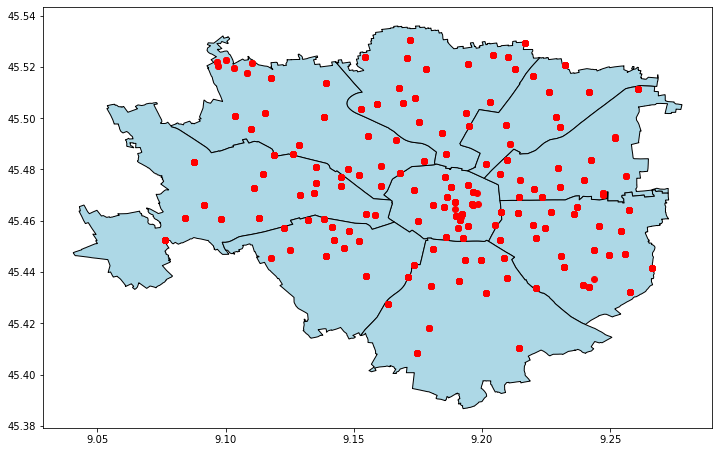

In [10]:
# Cell rappresentation with Geopandas
geo_data = geopandas.GeoDataFrame(locations, geometry=geopandas.points_from_xy(locations.LONG_X, locations.LAT_Y))

# Plot the map
milan = geopandas.read_file(file_path+'ds379_municipi_label.geojson')
ax = milan.plot(color='lightblue', edgecolor='black', figsize=[12,15])

# Plot the cells
geo_data.plot(ax=ax, color='red')
plt.show()


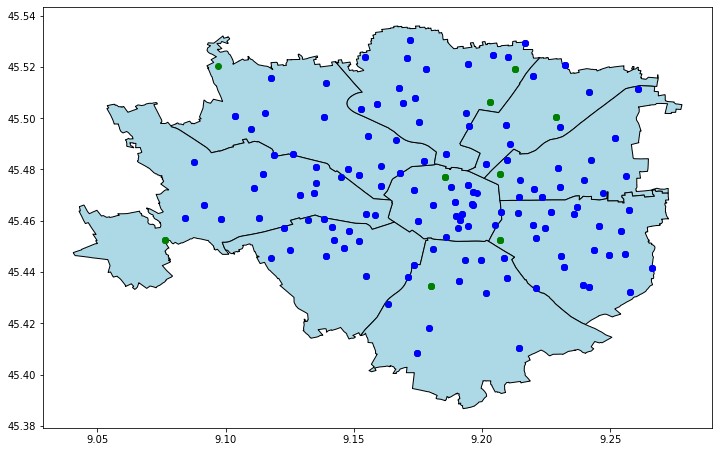

In [11]:
# Cell differentiation with Geopandas
geo_data_residential = geopandas.GeoDataFrame(residential_locations, geometry=geopandas.points_from_xy(residential_locations.LONG_X, residential_locations.LAT_Y))
geo_data_business = geopandas.GeoDataFrame(business_locations, geometry=geopandas.points_from_xy(business_locations.LONG_X, business_locations.LAT_Y))

# Plot the map
milan = geopandas.read_file(file_path+'ds379_municipi_label.geojson')
ax = milan.plot(color='lightblue', edgecolor='black', figsize=[12,15])

# Plot the cells
geo_data_residential.plot(ax=ax, color='green')
geo_data_business.plot(ax=ax, color='blue')
plt.show()

In [24]:
# This section makes a box plot of the daily statiscs regarding the number of connected 
# users to the cell taken as example. For each day, the following statistics are extracted from the considered
# KPI:
# - Median Value
# - 25th and 75th Quantiles
# - Max and Min values

# For reference about how to read a box plot go here: 
# https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51


def data_dataset_daily(dataset, ref_KPI):
  # Set Daily granularity instead of Hourly granularity
  dataset['Date'] = pd.to_datetime(dataset['Date']).dt.date
  # Set new dataset index to "Date" and keep only the "ref_KPI" column
  return dataset.set_index('Date').sort_values('Date').loc[:, [ref_KPI]]


# If operation == 0 do the sum of the ref_KPI of the day
# If operation == 1 do the average of the ref_KPI of the day
def dataset_operation(dataset, operation):
  if operation == 0:
    dataset = dataset.groupby(level=0).sum()
  else:
    dataset = dataset.groupby(level=0).mean()
  return dataset


def statistical_comparison(periods_lables, median_values, average_values, sd_values, id_1, id_2, ref_KPI):
  print('>>>------', periods_lables[id_1], ref_KPI, 'Variation ------<<<')
  print("Median difference between [", periods_lables[id_1] ,"] and [",periods_lables[id_2] ,"]: {0:.2f}%".format(((median_values[id_2] - median_values[id_1]) / abs(median_values[id_1])) * 100))
  print("Average difference between [", periods_lables[id_1] ,"] and [",periods_lables[id_2] ,"]: {0:.2f}%".format(((average_values[id_2] - average_values[id_1]) / abs(average_values[id_1])) * 100))
  print("Std. deviation difference between [", periods_lables[id_1] ,"] and [",periods_lables[id_2] ,"]: {0:.2f}%".format(((sd_values[id_2] - sd_values[id_1]) / abs(sd_values[id_1])) * 100))


def periods_box_plot_daily(periods, periods_lables, ref_KPI, operation, ylabel):

  periods_copy = []
  periods_data_list = []
  N_periods = len(periods)

  for i in range(N_periods):
    periods_copy.append(periods[i].copy())
    periods_copy[i] = data_dataset_daily(periods_copy[i], ref_KPI)
    periods_copy[i] = periods_copy[i].loc[:, [ref_KPI]].drop(datetime.date(year=2020,month=3,day=31), errors='ignore')
    periods_copy[i] = dataset_operation(periods_copy[i], ref_KPI)
    # periods_copy have only one KPI but we need "[ref_KPI]" to use the "tolist()" function
    periods_data_list.append(periods_copy[i][ref_KPI].tolist())

  # open new figure
  fig, ax = plt.subplots(figsize=(15,8))

  bplots = []
  for i in range(N_periods):
    bplots.append(ax.boxplot(periods_data_list[i], positions = [i], patch_artist=True))

  for bplot in bplots:
    for patch in bplot['boxes']:
      patch.set_facecolor('lightblue')

  # Set plotting options
  plt.xticks(color='black')
  plt.yticks(color='black')
  plt.grid(1)
  plt.xticks(ticks = list(range(N_periods)), labels = periods_lables, fontsize = 14)
  plt.setp( ax.xaxis.get_majorticklabels(), ha="center") 
  plt.ylabel(ylabel, color='black', fontsize=14)
  if N_periods > 3:
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor") 

  plt.title('Box Plot of Median '+ref_KPI+' - ALL CELLs', fontsize=14)
  plt.show()

  print()
  
  median_values = []
  average_values = []
  sd_values = []

  # Print statistical informations:
  for i in range(N_periods):
    print('---------', periods_lables[i], ref_KPI,'---------')
    median_values.append(np.median(periods_data_list[i]))
    print('Median value:', "{0:.2f}".format(median_values[i]))
    average_values.append(np.mean(periods_data_list[i]))
    print('Average value:', "{0:.2f}".format( average_values[i]))
    sd_values.append(np.std(periods_data_list[i]))
    print('Standard deviation:', "{0:.2f}".format(sd_values[i]))

  if N_periods > 3:
    # Statistical comparison between residential and business in the same period
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 0, 1, ref_KPI)
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 2, 3, ref_KPI)
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 4, 5, ref_KPI)

    # Statistical comparison between residential periods
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 0, 2, ref_KPI)
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 0, 4, ref_KPI)
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 2, 4, ref_KPI)

    # Statistical comparison between business periods
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 1, 3, ref_KPI)
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 1, 5, ref_KPI)
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 3, 5, ref_KPI)
  else:
    # Statistical comparison between periods
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 0, 1, ref_KPI)
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 0, 2, ref_KPI)
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 1, 2, ref_KPI)


In [25]:
def plot_stats(periods, periods_lables):
  periods_box_plot_daily(periods, periods_lables, 'DL_VOL', 0, 'Bits')
  print()
  periods_box_plot_daily(periods, periods_lables, 'UL_VOL', 0, 'Bits')
  print()
  periods_box_plot_daily(periods, periods_lables, 'DL_THR_MAX', 1, 'Bits')
  print()
  periods_box_plot_daily(periods, periods_lables, 'UL_THR_MAX', 1, 'Bits')
  print()
  periods_box_plot_daily(periods, periods_lables, 'DL_THR_AVG', 1, 'Bits')
  print()
  periods_box_plot_daily(periods, periods_lables, 'UL_THR_AVG', 1, 'Bits')
  print()
  periods_box_plot_daily(periods, periods_lables, 'ERAB_S_SR', 1, 'Success Rate')
  print()
  periods_box_plot_daily(periods, periods_lables, 'CS_SR', 1, 'Calls')
  print()
  periods_box_plot_daily(periods, periods_lables, 'RRC_S_SR', 1, 'Success Rate')
  print()
  periods_box_plot_daily(periods, periods_lables, 'RRC_RE_SR', 1, 'Success Rate')
  print()
  periods_box_plot_daily(periods, periods_lables, 'IntraF_Hout_SR', 1, 'Success Rate')
  print()
  periods_box_plot_daily(periods, periods_lables, 'InterF_Hout_SR', 1, 'Success Rate')
  print()
  periods_box_plot_daily(periods, periods_lables, 'Hin_SR', 1, 'Success Rate')
  print()
  periods_box_plot_daily(periods, periods_lables, 'PRB_DL_Used_Avg', 1, 'Bits')
  print()
  periods_box_plot_daily(periods, periods_lables, 'PRB_UL_Used_Avg', 1, 'Bits')
  print()

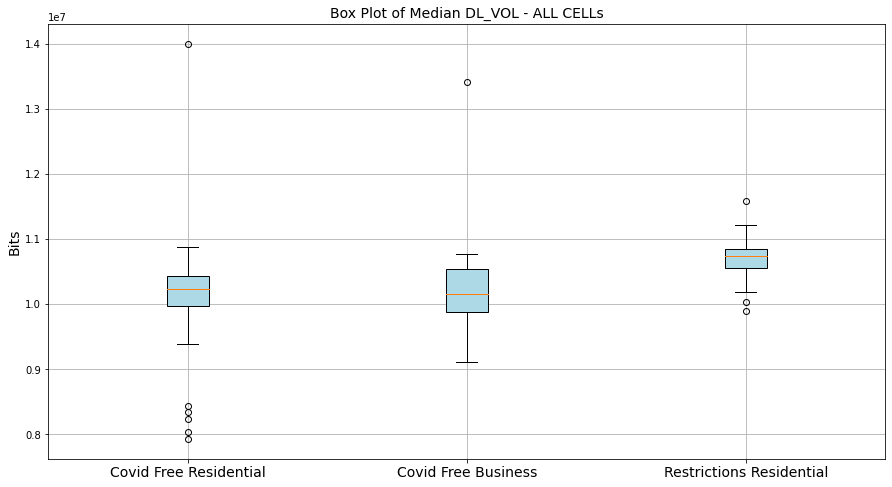


--------- Covid Free Residential DL_VOL ---------
Median value: 10228299.84
Average value: 10098197.62
Standard deviation: 897092.93
--------- Covid Free Business DL_VOL ---------
Median value: 10155150.32
Average value: 10218866.57
Standard deviation: 820310.10
--------- Restrictions Residential DL_VOL ---------
Median value: 10736376.01
Average value: 10692283.22
Standard deviation: 380883.26
>>>------ Covid Free Residential DL_VOL Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Covid Free Business ]: -0.72%
Average difference between [ Covid Free Residential ] and [ Covid Free Business ]: 1.19%
Std. deviation difference between [ Covid Free Residential ] and [ Covid Free Business ]: -8.56%
>>>------ Covid Free Residential DL_VOL Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Restrictions Residential ]: 4.97%
Average difference between [ Covid Free Residential ] and [ Restrictions Residential ]: 5.88%
Std. deviation diff

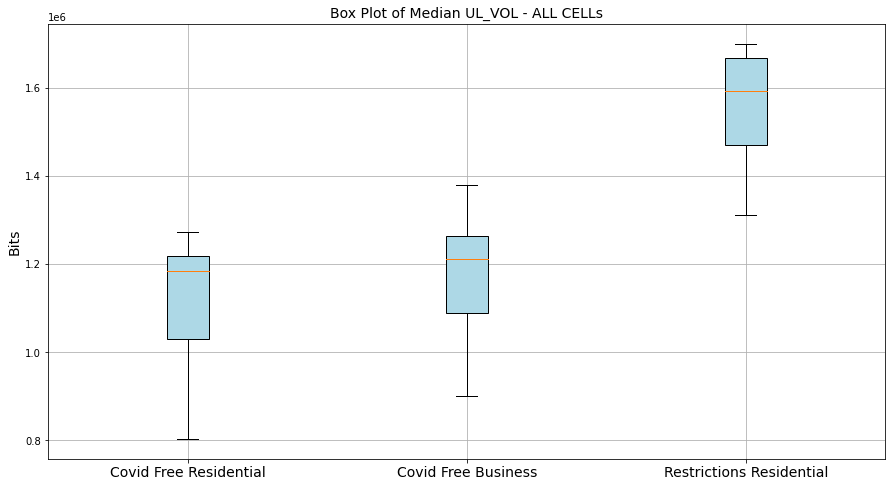


--------- Covid Free Residential UL_VOL ---------
Median value: 1185227.90
Average value: 1119706.01
Standard deviation: 130533.09
--------- Covid Free Business UL_VOL ---------
Median value: 1211847.29
Average value: 1168873.07
Standard deviation: 132182.07
--------- Restrictions Residential UL_VOL ---------
Median value: 1592944.30
Average value: 1562048.34
Standard deviation: 117307.45
>>>------ Covid Free Residential UL_VOL Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Covid Free Business ]: 2.25%
Average difference between [ Covid Free Residential ] and [ Covid Free Business ]: 4.39%
Std. deviation difference between [ Covid Free Residential ] and [ Covid Free Business ]: 1.26%
>>>------ Covid Free Residential UL_VOL Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Restrictions Residential ]: 34.40%
Average difference between [ Covid Free Residential ] and [ Restrictions Residential ]: 39.51%
Std. deviation difference

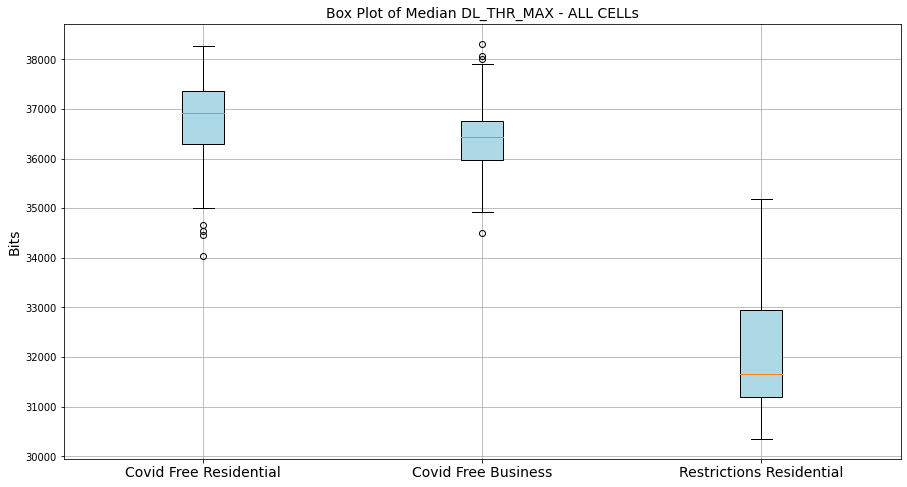


--------- Covid Free Residential DL_THR_MAX ---------
Median value: 36921.34
Average value: 36688.49
Standard deviation: 962.73
--------- Covid Free Business DL_THR_MAX ---------
Median value: 36431.24
Average value: 36451.33
Standard deviation: 952.23
--------- Restrictions Residential DL_THR_MAX ---------
Median value: 31657.86
Average value: 32185.83
Standard deviation: 1308.02
>>>------ Covid Free Residential DL_THR_MAX Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Covid Free Business ]: -1.33%
Average difference between [ Covid Free Residential ] and [ Covid Free Business ]: -0.65%
Std. deviation difference between [ Covid Free Residential ] and [ Covid Free Business ]: -1.09%
>>>------ Covid Free Residential DL_THR_MAX Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Restrictions Residential ]: -14.26%
Average difference between [ Covid Free Residential ] and [ Restrictions Residential ]: -12.27%
Std. deviation diffe

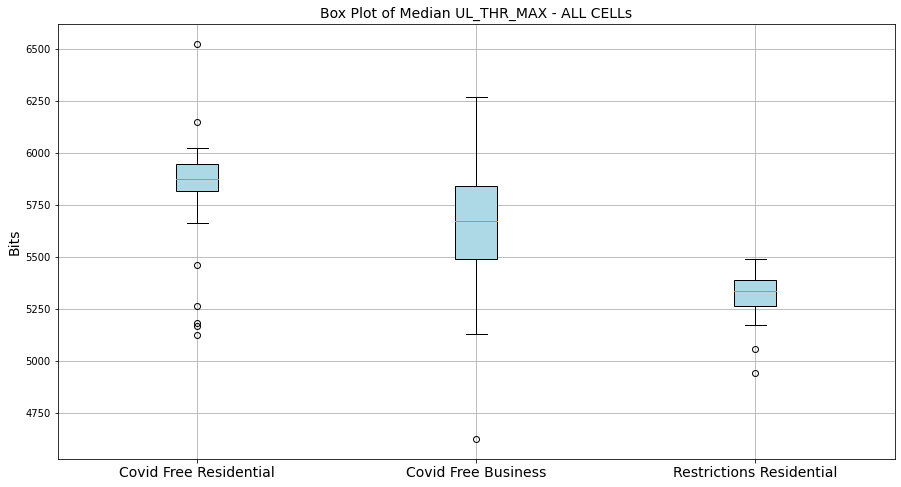


--------- Covid Free Residential UL_THR_MAX ---------
Median value: 5875.97
Average value: 5832.88
Standard deviation: 242.88
--------- Covid Free Business UL_THR_MAX ---------
Median value: 5674.36
Average value: 5662.31
Standard deviation: 378.19
--------- Restrictions Residential UL_THR_MAX ---------
Median value: 5333.43
Average value: 5303.49
Standard deviation: 128.26
>>>------ Covid Free Residential UL_THR_MAX Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Covid Free Business ]: -3.43%
Average difference between [ Covid Free Residential ] and [ Covid Free Business ]: -2.92%
Std. deviation difference between [ Covid Free Residential ] and [ Covid Free Business ]: 55.71%
>>>------ Covid Free Residential UL_THR_MAX Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Restrictions Residential ]: -9.23%
Average difference between [ Covid Free Residential ] and [ Restrictions Residential ]: -9.08%
Std. deviation difference bet

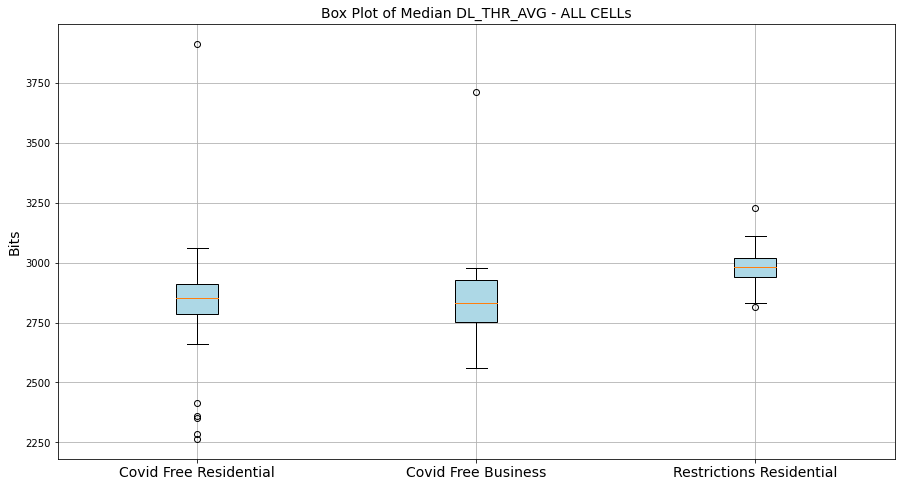


--------- Covid Free Residential DL_THR_AVG ---------
Median value: 2851.08
Average value: 2822.99
Standard deviation: 239.82
--------- Covid Free Business DL_THR_AVG ---------
Median value: 2829.85
Average value: 2846.64
Standard deviation: 218.02
--------- Restrictions Residential DL_THR_AVG ---------
Median value: 2979.95
Average value: 2982.10
Standard deviation: 90.86
>>>------ Covid Free Residential DL_THR_AVG Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Covid Free Business ]: -0.74%
Average difference between [ Covid Free Residential ] and [ Covid Free Business ]: 0.84%
Std. deviation difference between [ Covid Free Residential ] and [ Covid Free Business ]: -9.09%
>>>------ Covid Free Residential DL_THR_AVG Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Restrictions Residential ]: 4.52%
Average difference between [ Covid Free Residential ] and [ Restrictions Residential ]: 5.64%
Std. deviation difference between

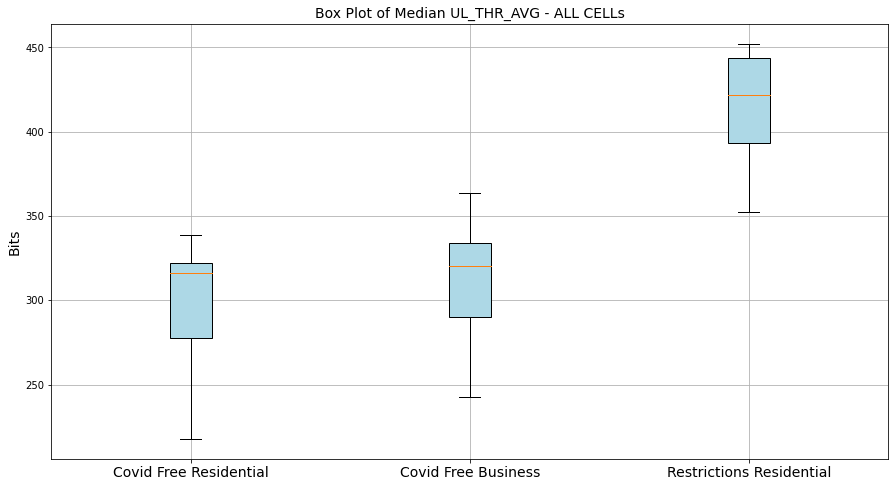


--------- Covid Free Residential UL_THR_AVG ---------
Median value: 316.21
Average value: 298.66
Standard deviation: 32.52
--------- Covid Free Business UL_THR_AVG ---------
Median value: 320.31
Average value: 310.13
Standard deviation: 33.48
--------- Restrictions Residential UL_THR_AVG ---------
Median value: 421.88
Average value: 416.74
Standard deviation: 29.52
>>>------ Covid Free Residential UL_THR_AVG Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Covid Free Business ]: 1.30%
Average difference between [ Covid Free Residential ] and [ Covid Free Business ]: 3.84%
Std. deviation difference between [ Covid Free Residential ] and [ Covid Free Business ]: 2.96%
>>>------ Covid Free Residential UL_THR_AVG Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Restrictions Residential ]: 33.41%
Average difference between [ Covid Free Residential ] and [ Restrictions Residential ]: 39.54%
Std. deviation difference between [ Covid

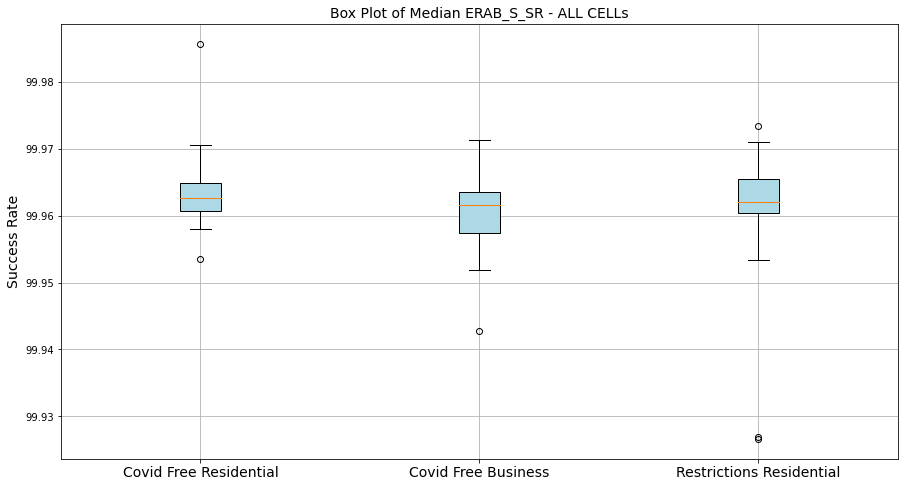


--------- Covid Free Residential ERAB_S_SR ---------
Median value: 99.96
Average value: 99.96
Standard deviation: 0.00
--------- Covid Free Business ERAB_S_SR ---------
Median value: 99.96
Average value: 99.96
Standard deviation: 0.01
--------- Restrictions Residential ERAB_S_SR ---------
Median value: 99.96
Average value: 99.96
Standard deviation: 0.01
>>>------ Covid Free Residential ERAB_S_SR Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Covid Free Business ]: -0.00%
Average difference between [ Covid Free Residential ] and [ Covid Free Business ]: -0.00%
Std. deviation difference between [ Covid Free Residential ] and [ Covid Free Business ]: 29.56%
>>>------ Covid Free Residential ERAB_S_SR Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Restrictions Residential ]: -0.00%
Average difference between [ Covid Free Residential ] and [ Restrictions Residential ]: -0.00%
Std. deviation difference between [ Covid Free Resid

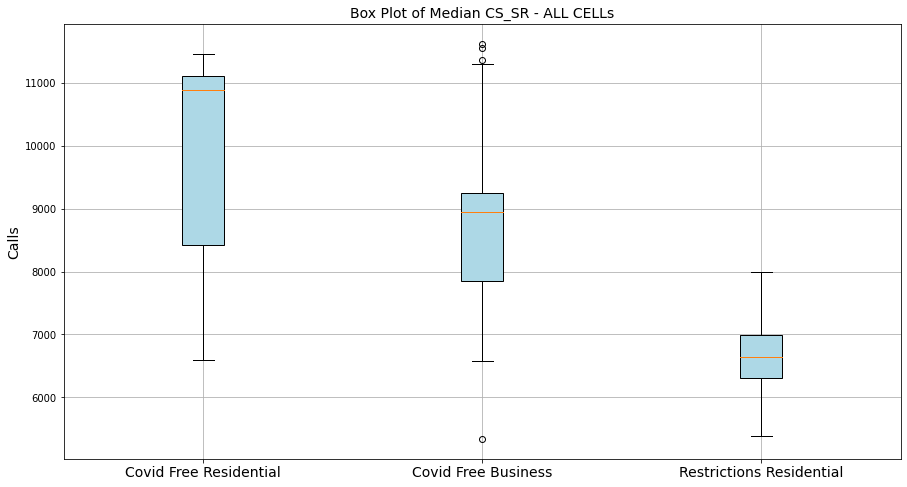


--------- Covid Free Residential CS_SR ---------
Median value: 10881.89
Average value: 9870.74
Standard deviation: 1529.75
--------- Covid Free Business CS_SR ---------
Median value: 8950.49
Average value: 8801.19
Standard deviation: 1643.62
--------- Restrictions Residential CS_SR ---------
Median value: 6640.26
Average value: 6731.95
Standard deviation: 633.76
>>>------ Covid Free Residential CS_SR Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Covid Free Business ]: -17.75%
Average difference between [ Covid Free Residential ] and [ Covid Free Business ]: -10.84%
Std. deviation difference between [ Covid Free Residential ] and [ Covid Free Business ]: 7.44%
>>>------ Covid Free Residential CS_SR Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Restrictions Residential ]: -38.98%
Average difference between [ Covid Free Residential ] and [ Restrictions Residential ]: -31.80%
Std. deviation difference between [ Covid Free R

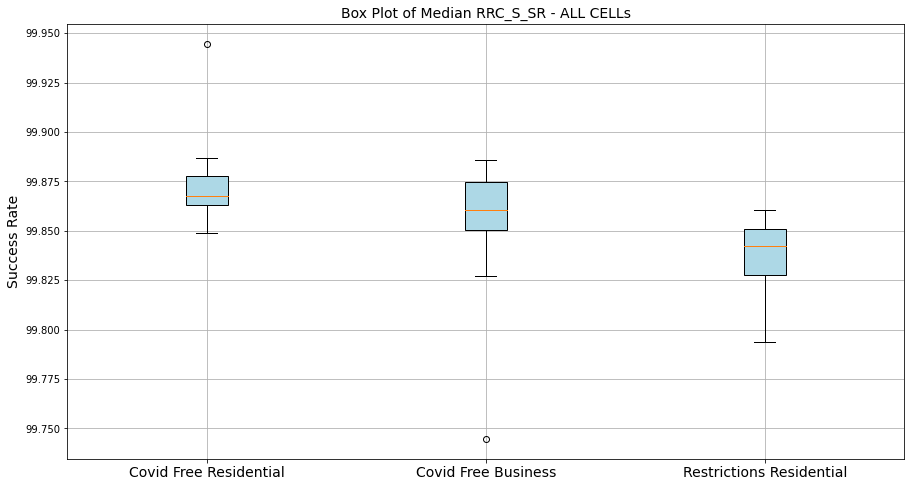


--------- Covid Free Residential RRC_S_SR ---------
Median value: 99.87
Average value: 99.87
Standard deviation: 0.01
--------- Covid Free Business RRC_S_SR ---------
Median value: 99.86
Average value: 99.86
Standard deviation: 0.03
--------- Restrictions Residential RRC_S_SR ---------
Median value: 99.84
Average value: 99.84
Standard deviation: 0.02
>>>------ Covid Free Residential RRC_S_SR Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Covid Free Business ]: -0.01%
Average difference between [ Covid Free Residential ] and [ Covid Free Business ]: -0.01%
Std. deviation difference between [ Covid Free Residential ] and [ Covid Free Business ]: 99.34%
>>>------ Covid Free Residential RRC_S_SR Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Restrictions Residential ]: -0.03%
Average difference between [ Covid Free Residential ] and [ Restrictions Residential ]: -0.03%
Std. deviation difference between [ Covid Free Residentia

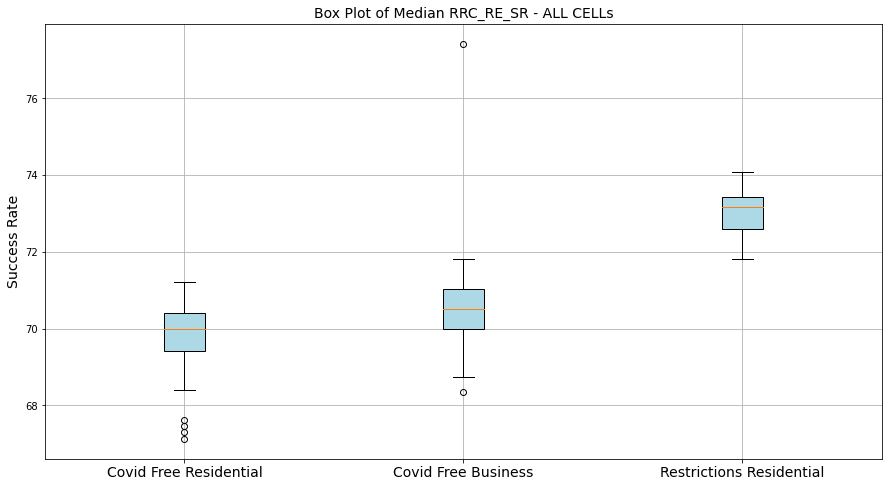


--------- Covid Free Residential RRC_RE_SR ---------
Median value: 69.99
Average value: 69.77
Standard deviation: 0.95
--------- Covid Free Business RRC_RE_SR ---------
Median value: 70.50
Average value: 70.67
Standard deviation: 1.63
--------- Restrictions Residential RRC_RE_SR ---------
Median value: 73.17
Average value: 73.05
Standard deviation: 0.60
>>>------ Covid Free Residential RRC_RE_SR Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Covid Free Business ]: 0.73%
Average difference between [ Covid Free Residential ] and [ Covid Free Business ]: 1.28%
Std. deviation difference between [ Covid Free Residential ] and [ Covid Free Business ]: 71.04%
>>>------ Covid Free Residential RRC_RE_SR Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Restrictions Residential ]: 4.54%
Average difference between [ Covid Free Residential ] and [ Restrictions Residential ]: 4.70%
Std. deviation difference between [ Covid Free Residenti

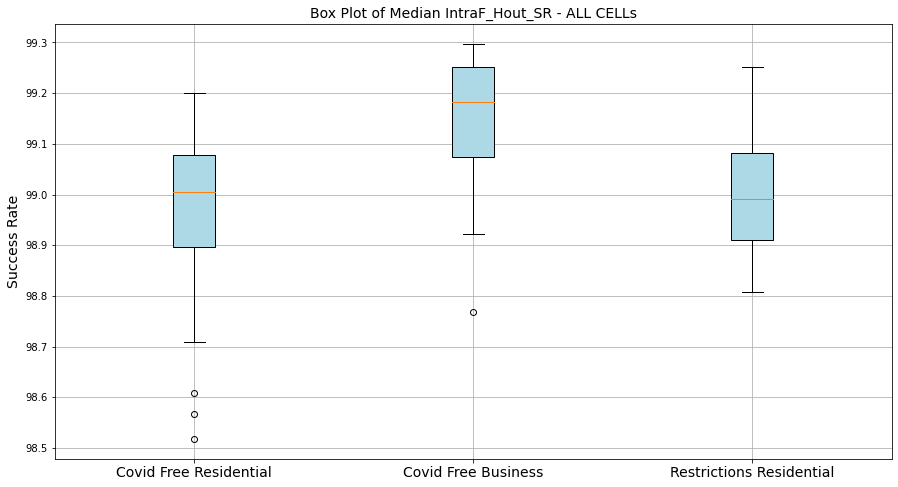


--------- Covid Free Residential IntraF_Hout_SR ---------
Median value: 99.01
Average value: 98.97
Standard deviation: 0.16
--------- Covid Free Business IntraF_Hout_SR ---------
Median value: 99.18
Average value: 99.15
Standard deviation: 0.13
--------- Restrictions Residential IntraF_Hout_SR ---------
Median value: 98.99
Average value: 99.00
Standard deviation: 0.12
>>>------ Covid Free Residential IntraF_Hout_SR Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Covid Free Business ]: 0.18%
Average difference between [ Covid Free Residential ] and [ Covid Free Business ]: 0.18%
Std. deviation difference between [ Covid Free Residential ] and [ Covid Free Business ]: -20.25%
>>>------ Covid Free Residential IntraF_Hout_SR Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Restrictions Residential ]: -0.02%
Average difference between [ Covid Free Residential ] and [ Restrictions Residential ]: 0.03%
Std. deviation difference bet

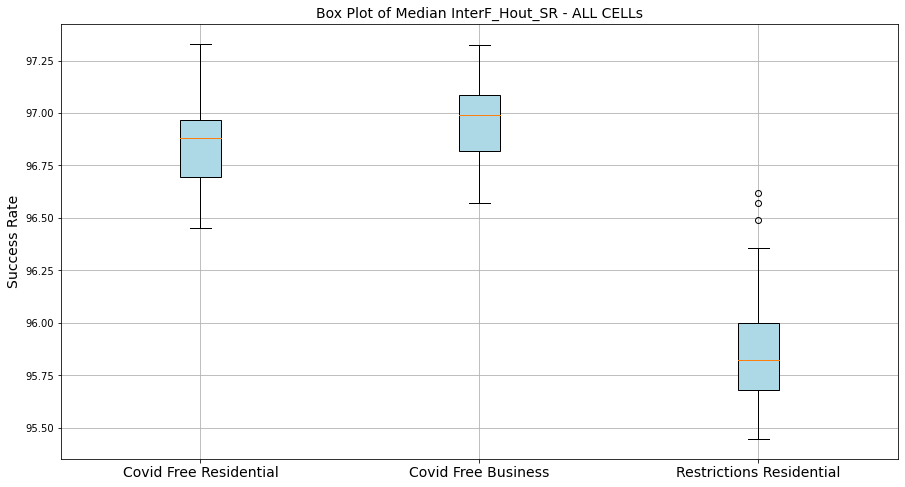


--------- Covid Free Residential InterF_Hout_SR ---------
Median value: 96.88
Average value: 96.85
Standard deviation: 0.21
--------- Covid Free Business InterF_Hout_SR ---------
Median value: 96.99
Average value: 96.97
Standard deviation: 0.20
--------- Restrictions Residential InterF_Hout_SR ---------
Median value: 95.82
Average value: 95.91
Standard deviation: 0.32
>>>------ Covid Free Residential InterF_Hout_SR Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Covid Free Business ]: 0.11%
Average difference between [ Covid Free Residential ] and [ Covid Free Business ]: 0.12%
Std. deviation difference between [ Covid Free Residential ] and [ Covid Free Business ]: -4.99%
>>>------ Covid Free Residential InterF_Hout_SR Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Restrictions Residential ]: -1.09%
Average difference between [ Covid Free Residential ] and [ Restrictions Residential ]: -0.97%
Std. deviation difference bet

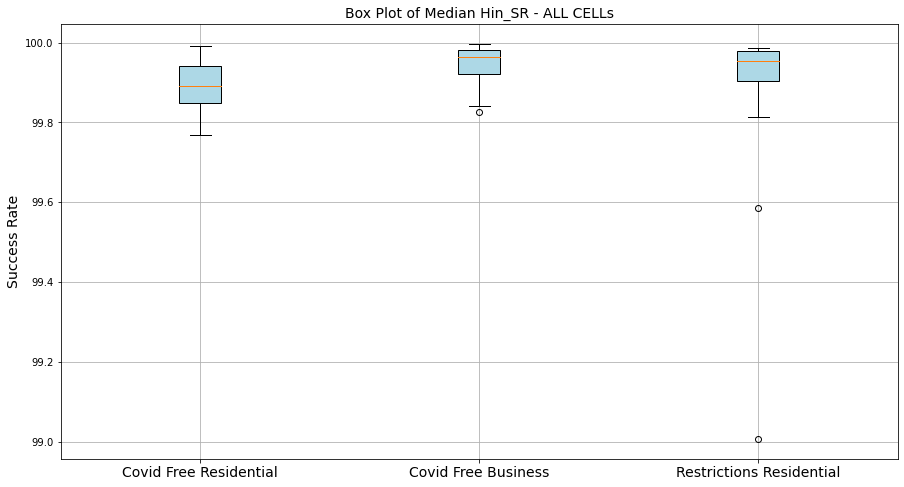


--------- Covid Free Residential Hin_SR ---------
Median value: 99.89
Average value: 99.90
Standard deviation: 0.06
--------- Covid Free Business Hin_SR ---------
Median value: 99.96
Average value: 99.94
Standard deviation: 0.05
--------- Restrictions Residential Hin_SR ---------
Median value: 99.95
Average value: 99.88
Standard deviation: 0.21
>>>------ Covid Free Residential Hin_SR Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Covid Free Business ]: 0.07%
Average difference between [ Covid Free Residential ] and [ Covid Free Business ]: 0.05%
Std. deviation difference between [ Covid Free Residential ] and [ Covid Free Business ]: -13.86%
>>>------ Covid Free Residential Hin_SR Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Restrictions Residential ]: 0.06%
Average difference between [ Covid Free Residential ] and [ Restrictions Residential ]: -0.01%
Std. deviation difference between [ Covid Free Residential ] and [ Re

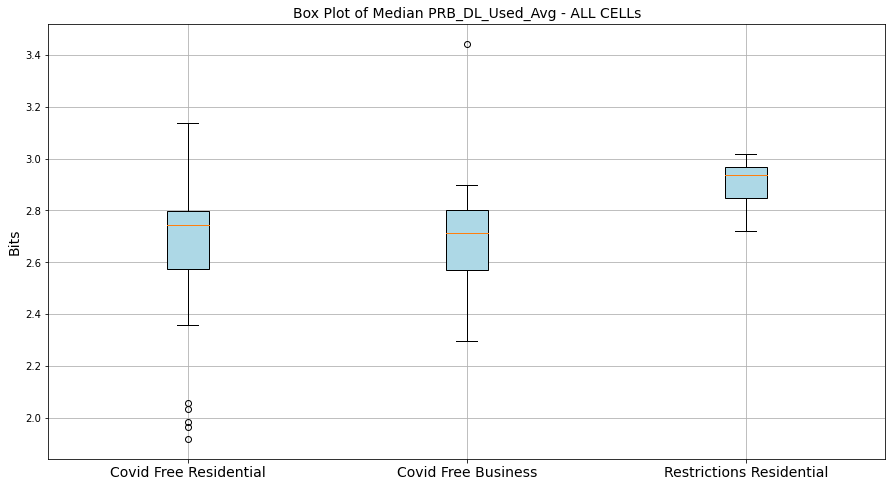


--------- Covid Free Residential PRB_DL_Used_Avg ---------
Median value: 2.74
Average value: 2.64
Standard deviation: 0.26
--------- Covid Free Business PRB_DL_Used_Avg ---------
Median value: 2.71
Average value: 2.69
Standard deviation: 0.23
--------- Restrictions Residential PRB_DL_Used_Avg ---------
Median value: 2.94
Average value: 2.90
Standard deviation: 0.09
>>>------ Covid Free Residential PRB_DL_Used_Avg Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Covid Free Business ]: -1.02%
Average difference between [ Covid Free Residential ] and [ Covid Free Business ]: 1.84%
Std. deviation difference between [ Covid Free Residential ] and [ Covid Free Business ]: -11.47%
>>>------ Covid Free Residential PRB_DL_Used_Avg Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Restrictions Residential ]: 7.09%
Average difference between [ Covid Free Residential ] and [ Restrictions Residential ]: 9.77%
Std. deviation difference betw

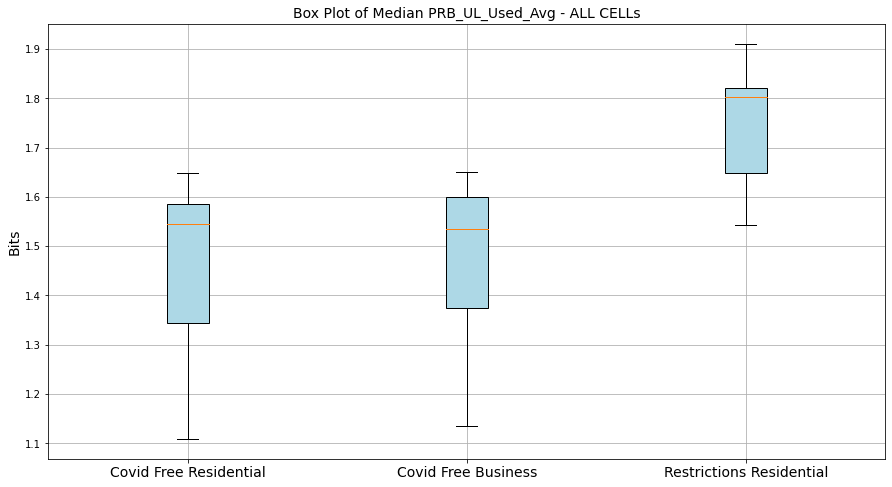


--------- Covid Free Residential PRB_UL_Used_Avg ---------
Median value: 1.55
Average value: 1.46
Standard deviation: 0.16
--------- Covid Free Business PRB_UL_Used_Avg ---------
Median value: 1.53
Average value: 1.47
Standard deviation: 0.16
--------- Restrictions Residential PRB_UL_Used_Avg ---------
Median value: 1.80
Average value: 1.75
Standard deviation: 0.11
>>>------ Covid Free Residential PRB_UL_Used_Avg Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Covid Free Business ]: -0.71%
Average difference between [ Covid Free Residential ] and [ Covid Free Business ]: 0.81%
Std. deviation difference between [ Covid Free Residential ] and [ Covid Free Business ]: 2.24%
>>>------ Covid Free Residential PRB_UL_Used_Avg Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Restrictions Residential ]: 16.70%
Average difference between [ Covid Free Residential ] and [ Restrictions Residential ]: 19.93%
Std. deviation difference betw

In [26]:
periods = [covid_free, restrictions, full_lockdown]
plot_stats(periods, periods_lables)

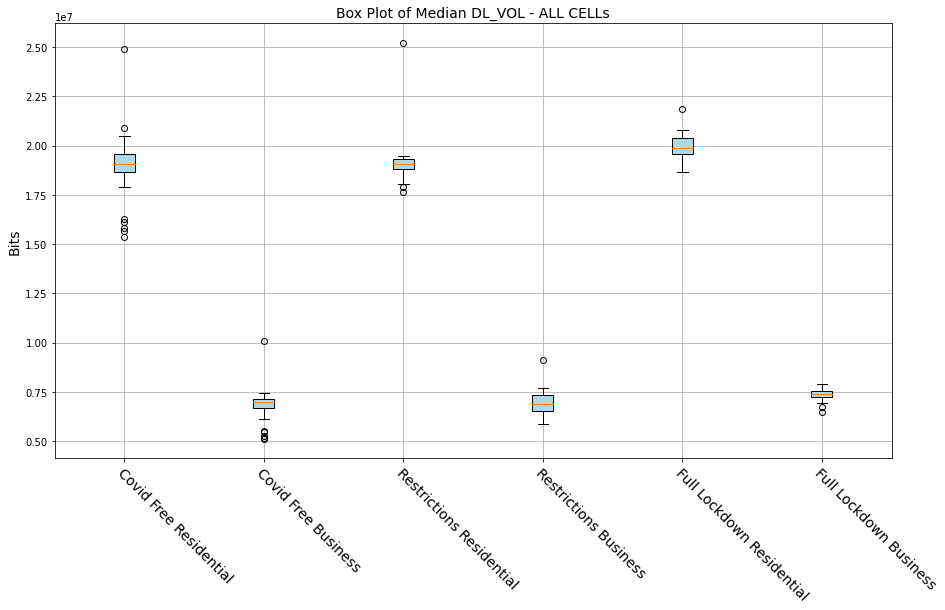


--------- Covid Free Residential DL_VOL ---------
Median value: 19083201.91
Average value: 18960207.91
Standard deviation: 1482278.73
--------- Covid Free Business DL_VOL ---------
Median value: 6965557.06
Average value: 6858593.93
Standard deviation: 748933.04
--------- Restrictions Residential DL_VOL ---------
Median value: 19070751.40
Average value: 19168539.06
Standard deviation: 1342647.81
--------- Restrictions Business DL_VOL ---------
Median value: 6906849.56
Average value: 6982756.25
Standard deviation: 685121.97
--------- Full Lockdown Residential DL_VOL ---------
Median value: 19879759.56
Average value: 19969477.00
Standard deviation: 709544.47
--------- Full Lockdown Business DL_VOL ---------
Median value: 7405715.27
Average value: 7330572.62
Standard deviation: 330777.04
>>>------ Covid Free Residential DL_VOL Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Covid Free Business ]: -63.50%
Average difference between [ Covid Free Residential ] 

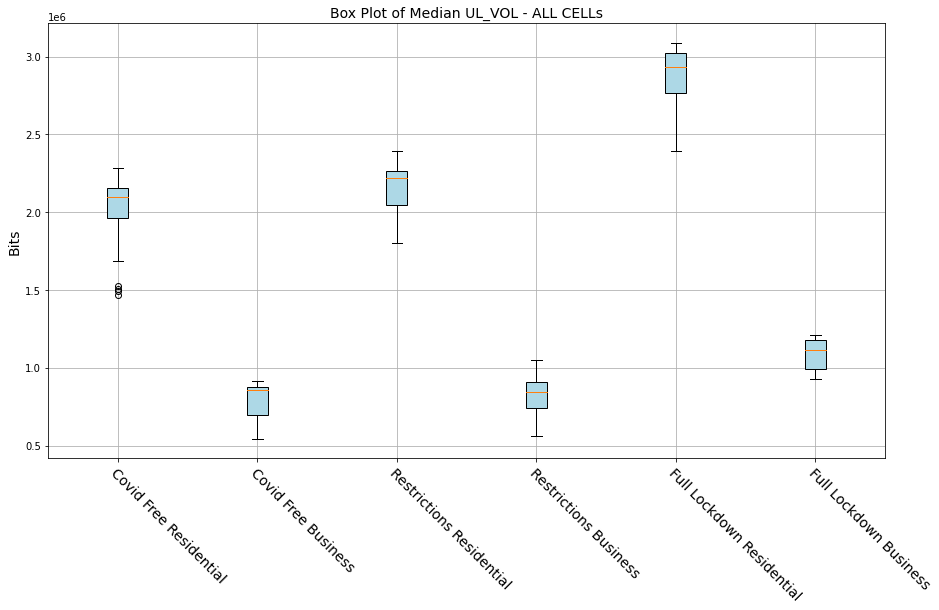


--------- Covid Free Residential UL_VOL ---------
Median value: 2098785.83
Average value: 2018868.55
Standard deviation: 200458.94
--------- Covid Free Business UL_VOL ---------
Median value: 859456.16
Average value: 791164.48
Standard deviation: 111003.25
--------- Restrictions Residential UL_VOL ---------
Median value: 2220728.55
Average value: 2152061.75
Standard deviation: 163783.24
--------- Restrictions Business UL_VOL ---------
Median value: 844035.57
Average value: 813368.78
Standard deviation: 123703.67
--------- Full Lockdown Residential UL_VOL ---------
Median value: 2934136.86
Average value: 2874519.99
Standard deviation: 189448.52
--------- Full Lockdown Business UL_VOL ---------
Median value: 1112228.04
Average value: 1086401.22
Standard deviation: 95037.43
>>>------ Covid Free Residential UL_VOL Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Covid Free Business ]: -59.05%
Average difference between [ Covid Free Residential ] and [ Covid F

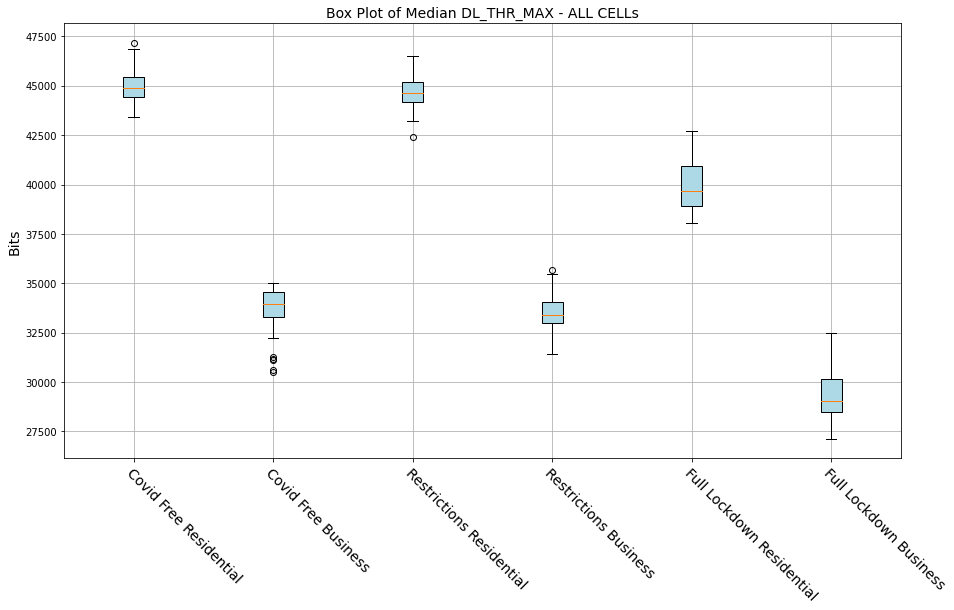


--------- Covid Free Residential DL_THR_MAX ---------
Median value: 44903.63
Average value: 44985.63
Standard deviation: 839.75
--------- Covid Free Business DL_THR_MAX ---------
Median value: 33968.40
Average value: 33650.76
Standard deviation: 1181.03
--------- Restrictions Residential DL_THR_MAX ---------
Median value: 44652.37
Average value: 44618.78
Standard deviation: 884.02
--------- Restrictions Business DL_THR_MAX ---------
Median value: 33399.03
Average value: 33498.49
Standard deviation: 1094.27
--------- Full Lockdown Residential DL_THR_MAX ---------
Median value: 39647.06
Average value: 39874.09
Standard deviation: 1353.38
--------- Full Lockdown Business DL_THR_MAX ---------
Median value: 29055.96
Average value: 29400.10
Standard deviation: 1348.79
>>>------ Covid Free Residential DL_THR_MAX Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Covid Free Business ]: -24.35%
Average difference between [ Covid Free Residential ] and [ Covid Free B

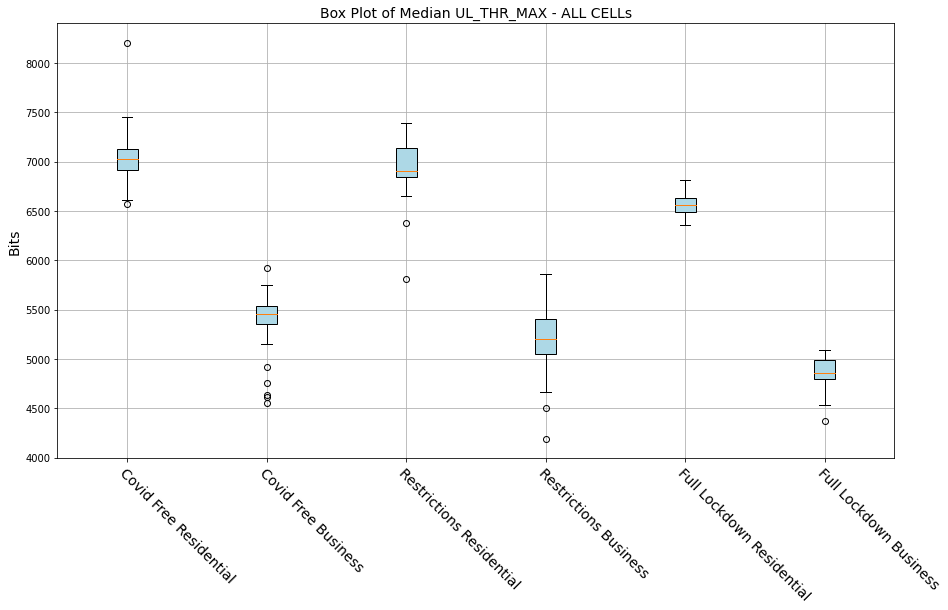


--------- Covid Free Residential UL_THR_MAX ---------
Median value: 7021.94
Average value: 7043.84
Standard deviation: 250.35
--------- Covid Free Business UL_THR_MAX ---------
Median value: 5451.17
Average value: 5389.66
Standard deviation: 276.58
--------- Restrictions Residential UL_THR_MAX ---------
Median value: 6906.23
Average value: 6925.93
Standard deviation: 327.14
--------- Restrictions Business UL_THR_MAX ---------
Median value: 5203.21
Average value: 5205.42
Standard deviation: 414.33
--------- Full Lockdown Residential UL_THR_MAX ---------
Median value: 6564.81
Average value: 6565.09
Standard deviation: 131.90
--------- Full Lockdown Business UL_THR_MAX ---------
Median value: 4855.49
Average value: 4846.34
Standard deviation: 171.37
>>>------ Covid Free Residential UL_THR_MAX Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Covid Free Business ]: -22.37%
Average difference between [ Covid Free Residential ] and [ Covid Free Business ]: -23.4

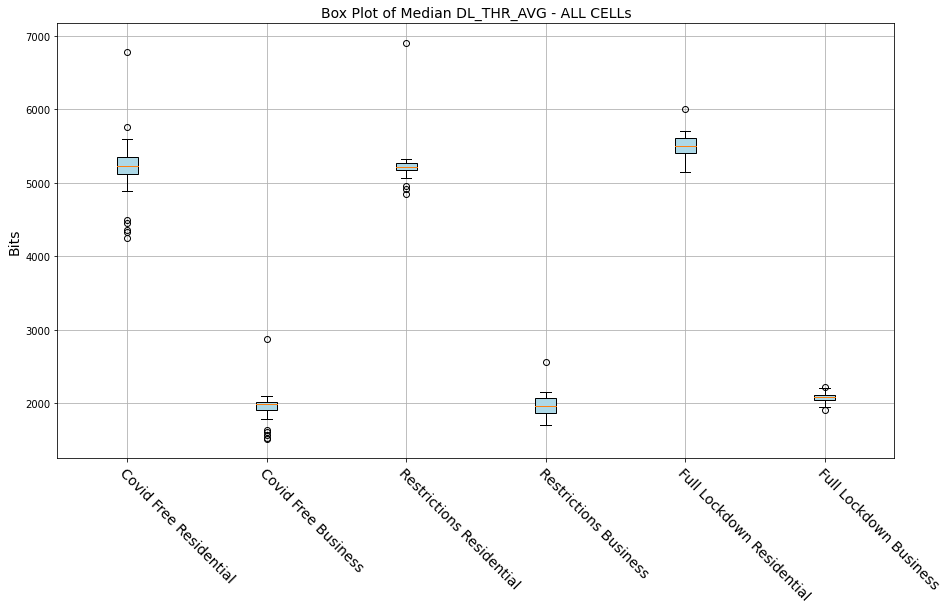


--------- Covid Free Residential DL_THR_AVG ---------
Median value: 5229.68
Average value: 5202.92
Standard deviation: 397.23
--------- Covid Free Business DL_THR_AVG ---------
Median value: 1985.55
Average value: 1952.97
Standard deviation: 197.62
--------- Restrictions Residential DL_THR_AVG ---------
Median value: 5221.37
Average value: 5258.27
Standard deviation: 364.22
--------- Restrictions Business DL_THR_AVG ---------
Median value: 1960.11
Average value: 1974.62
Standard deviation: 177.84
--------- Full Lockdown Residential DL_THR_AVG ---------
Median value: 5508.58
Average value: 5500.94
Standard deviation: 186.34
--------- Full Lockdown Business DL_THR_AVG ---------
Median value: 2080.09
Average value: 2069.37
Standard deviation: 75.72
>>>------ Covid Free Residential DL_THR_AVG Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Covid Free Business ]: -62.03%
Average difference between [ Covid Free Residential ] and [ Covid Free Business ]: -62.46

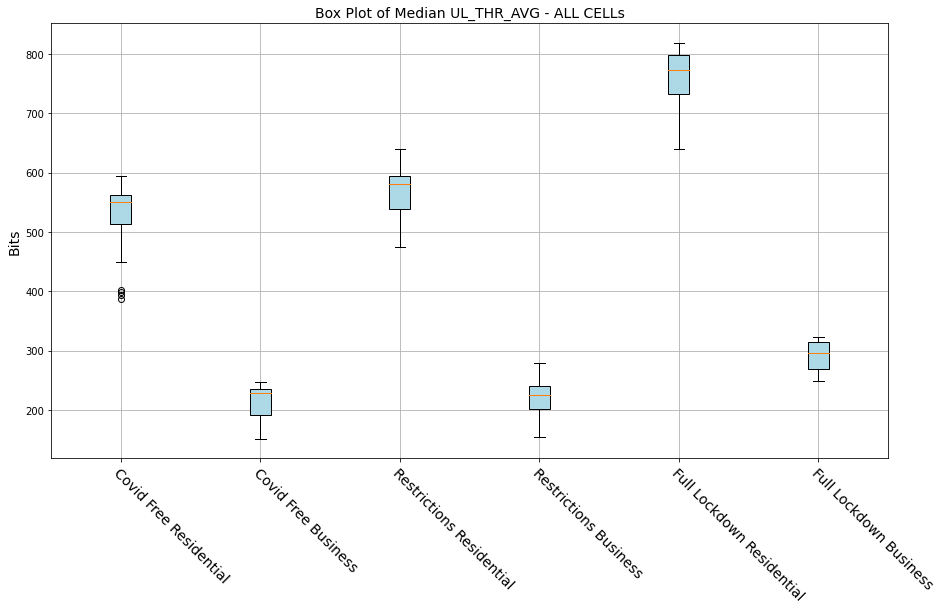


--------- Covid Free Residential UL_THR_AVG ---------
Median value: 550.55
Average value: 529.75
Standard deviation: 51.50
--------- Covid Free Business UL_THR_AVG ---------
Median value: 228.55
Average value: 214.23
Standard deviation: 27.15
--------- Restrictions Residential UL_THR_AVG ---------
Median value: 581.39
Average value: 564.76
Standard deviation: 43.16
--------- Restrictions Business UL_THR_AVG ---------
Median value: 224.68
Average value: 218.07
Standard deviation: 30.94
--------- Full Lockdown Residential UL_THR_AVG ---------
Median value: 772.64
Average value: 760.96
Standard deviation: 47.99
--------- Full Lockdown Business UL_THR_AVG ---------
Median value: 296.31
Average value: 291.99
Standard deviation: 23.73
>>>------ Covid Free Residential UL_THR_AVG Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Covid Free Business ]: -58.49%
Average difference between [ Covid Free Residential ] and [ Covid Free Business ]: -59.56%
Std. deviation 

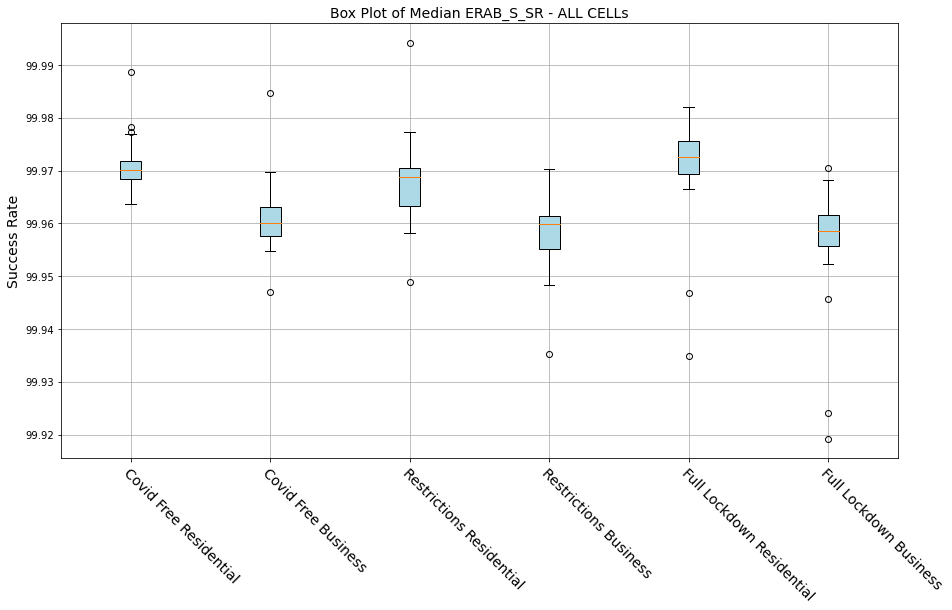


--------- Covid Free Residential ERAB_S_SR ---------
Median value: 99.97
Average value: 99.97
Standard deviation: 0.00
--------- Covid Free Business ERAB_S_SR ---------
Median value: 99.96
Average value: 99.96
Standard deviation: 0.01
--------- Restrictions Residential ERAB_S_SR ---------
Median value: 99.97
Average value: 99.97
Standard deviation: 0.01
--------- Restrictions Business ERAB_S_SR ---------
Median value: 99.96
Average value: 99.96
Standard deviation: 0.01
--------- Full Lockdown Residential ERAB_S_SR ---------
Median value: 99.97
Average value: 99.97
Standard deviation: 0.01
--------- Full Lockdown Business ERAB_S_SR ---------
Median value: 99.96
Average value: 99.96
Standard deviation: 0.01
>>>------ Covid Free Residential ERAB_S_SR Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Covid Free Business ]: -0.01%
Average difference between [ Covid Free Residential ] and [ Covid Free Business ]: -0.01%
Std. deviation difference between [ Covid 

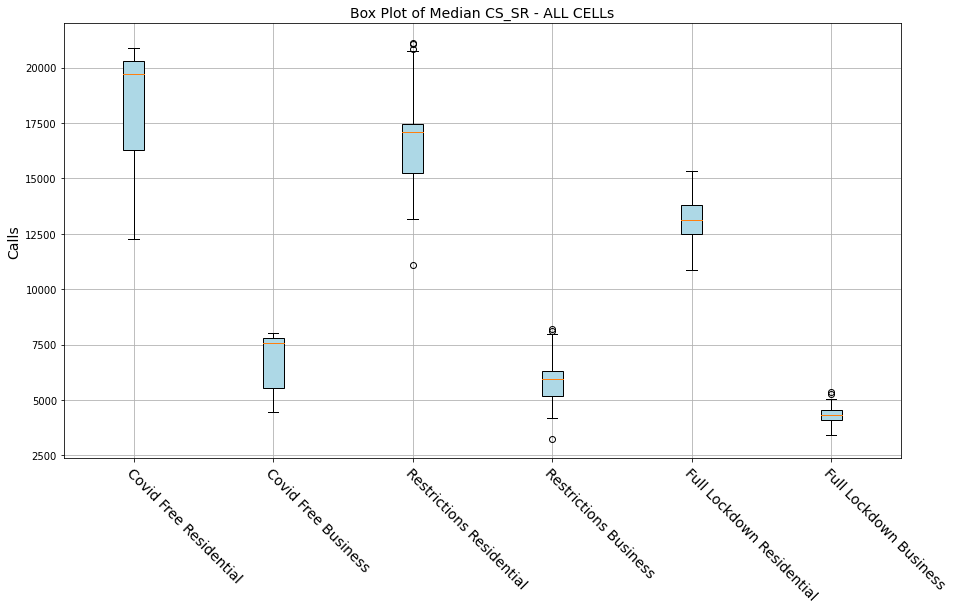


--------- Covid Free Residential CS_SR ---------
Median value: 19703.79
Average value: 18364.06
Standard deviation: 2458.30
--------- Covid Free Business CS_SR ---------
Median value: 7565.80
Average value: 6766.31
Standard deviation: 1215.30
--------- Restrictions Residential CS_SR ---------
Median value: 17087.56
Average value: 16777.89
Standard deviation: 2578.93
--------- Restrictions Business CS_SR ---------
Median value: 5953.11
Average value: 5916.87
Standard deviation: 1305.80
--------- Full Lockdown Residential CS_SR ---------
Median value: 13121.64
Average value: 13246.72
Standard deviation: 1112.52
--------- Full Lockdown Business CS_SR ---------
Median value: 4307.56
Average value: 4371.32
Standard deviation: 464.30
>>>------ Covid Free Residential CS_SR Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Covid Free Business ]: -61.60%
Average difference between [ Covid Free Residential ] and [ Covid Free Business ]: -63.15%
Std. deviation differ

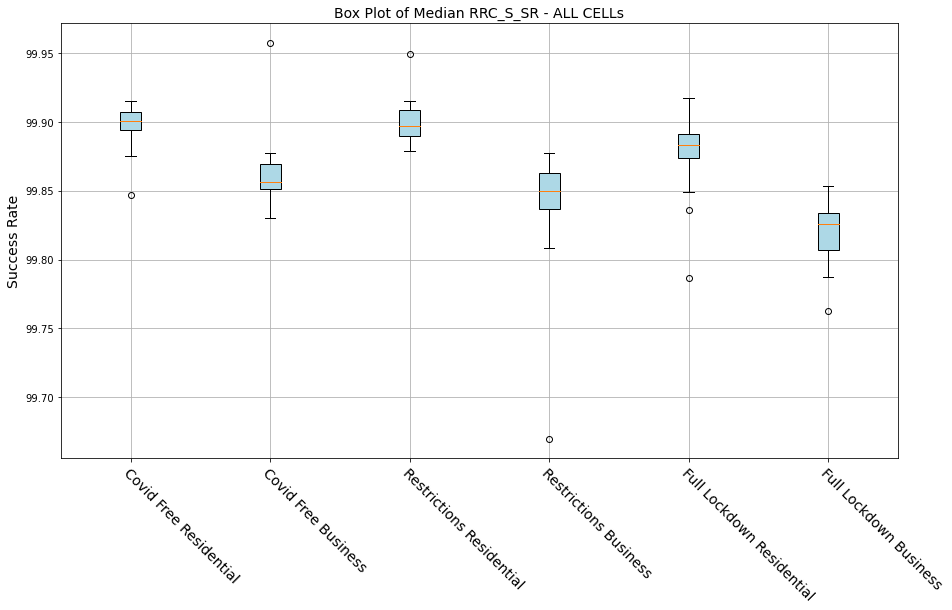


--------- Covid Free Residential RRC_S_SR ---------
Median value: 99.90
Average value: 99.90
Standard deviation: 0.01
--------- Covid Free Business RRC_S_SR ---------
Median value: 99.86
Average value: 99.86
Standard deviation: 0.02
--------- Restrictions Residential RRC_S_SR ---------
Median value: 99.90
Average value: 99.90
Standard deviation: 0.01
--------- Restrictions Business RRC_S_SR ---------
Median value: 99.85
Average value: 99.84
Standard deviation: 0.04
--------- Full Lockdown Residential RRC_S_SR ---------
Median value: 99.88
Average value: 99.88
Standard deviation: 0.03
--------- Full Lockdown Business RRC_S_SR ---------
Median value: 99.83
Average value: 99.82
Standard deviation: 0.02
>>>------ Covid Free Residential RRC_S_SR Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Covid Free Business ]: -0.04%
Average difference between [ Covid Free Residential ] and [ Covid Free Business ]: -0.04%
Std. deviation difference between [ Covid Free Re

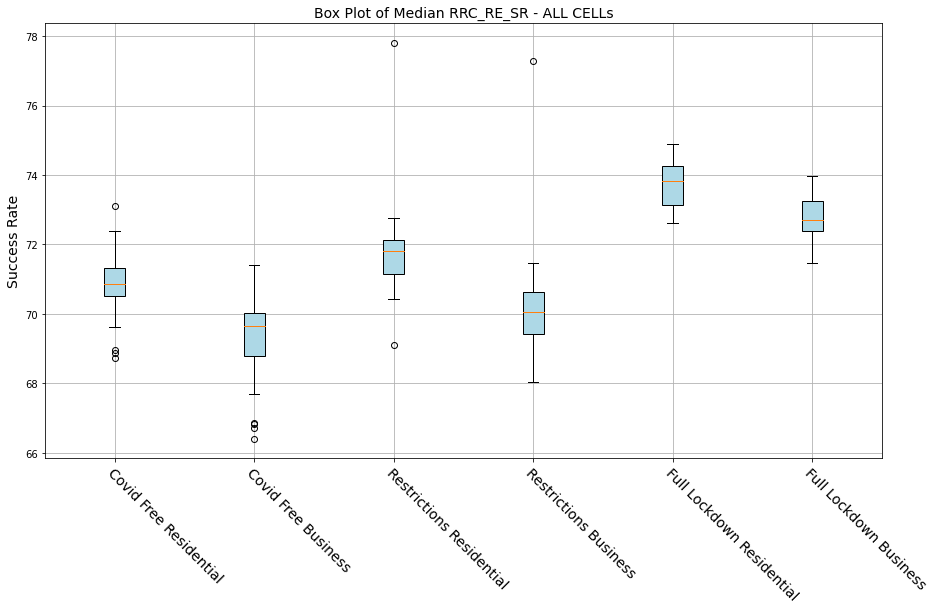


--------- Covid Free Residential RRC_RE_SR ---------
Median value: 70.86
Average value: 70.88
Standard deviation: 0.83
--------- Covid Free Business RRC_RE_SR ---------
Median value: 69.64
Average value: 69.34
Standard deviation: 1.11
--------- Restrictions Residential RRC_RE_SR ---------
Median value: 71.80
Average value: 71.82
Standard deviation: 1.49
--------- Restrictions Business RRC_RE_SR ---------
Median value: 70.04
Average value: 70.23
Standard deviation: 1.71
--------- Full Lockdown Residential RRC_RE_SR ---------
Median value: 73.83
Average value: 73.77
Standard deviation: 0.71
--------- Full Lockdown Business RRC_RE_SR ---------
Median value: 72.70
Average value: 72.77
Standard deviation: 0.62
>>>------ Covid Free Residential RRC_RE_SR Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Covid Free Business ]: -1.72%
Average difference between [ Covid Free Residential ] and [ Covid Free Business ]: -2.17%
Std. deviation difference between [ Covid 

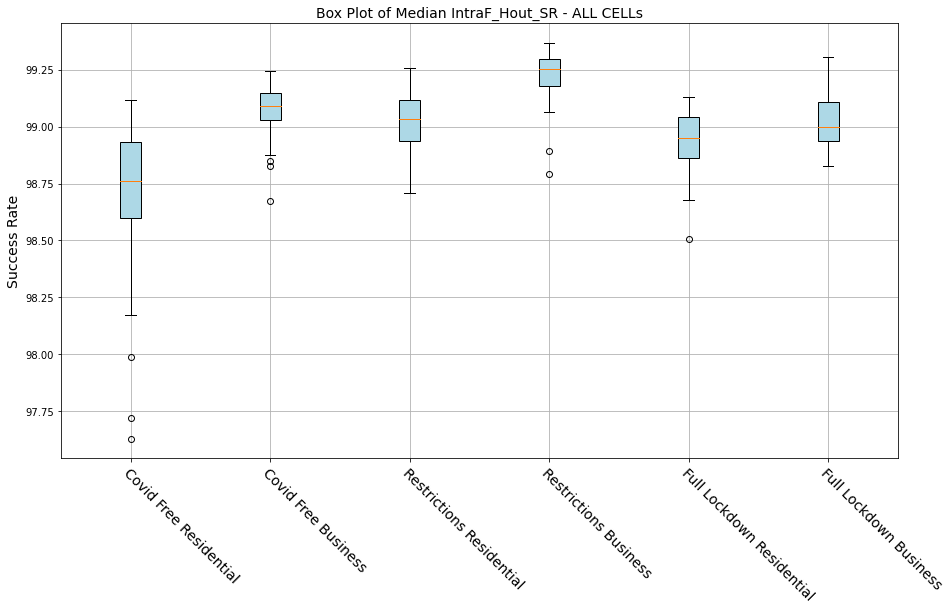


--------- Covid Free Residential IntraF_Hout_SR ---------
Median value: 98.76
Average value: 98.71
Standard deviation: 0.33
--------- Covid Free Business IntraF_Hout_SR ---------
Median value: 99.09
Average value: 99.07
Standard deviation: 0.12
--------- Restrictions Residential IntraF_Hout_SR ---------
Median value: 99.03
Average value: 99.00
Standard deviation: 0.15
--------- Restrictions Business IntraF_Hout_SR ---------
Median value: 99.25
Average value: 99.21
Standard deviation: 0.14
--------- Full Lockdown Residential IntraF_Hout_SR ---------
Median value: 98.95
Average value: 98.94
Standard deviation: 0.15
--------- Full Lockdown Business IntraF_Hout_SR ---------
Median value: 99.00
Average value: 99.02
Standard deviation: 0.12
>>>------ Covid Free Residential IntraF_Hout_SR Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Covid Free Business ]: 0.33%
Average difference between [ Covid Free Residential ] and [ Covid Free Business ]: 0.37%
Std. devi

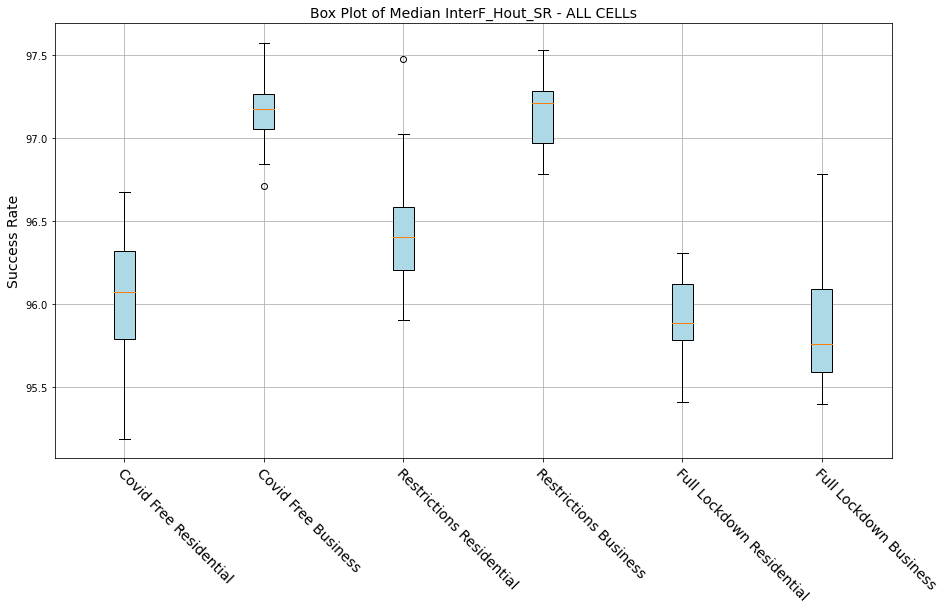


--------- Covid Free Residential InterF_Hout_SR ---------
Median value: 96.07
Average value: 96.02
Standard deviation: 0.39
--------- Covid Free Business InterF_Hout_SR ---------
Median value: 97.18
Average value: 97.16
Standard deviation: 0.18
--------- Restrictions Residential InterF_Hout_SR ---------
Median value: 96.40
Average value: 96.43
Standard deviation: 0.36
--------- Restrictions Business InterF_Hout_SR ---------
Median value: 97.21
Average value: 97.16
Standard deviation: 0.22
--------- Full Lockdown Residential InterF_Hout_SR ---------
Median value: 95.89
Average value: 95.93
Standard deviation: 0.24
--------- Full Lockdown Business InterF_Hout_SR ---------
Median value: 95.76
Average value: 95.91
Standard deviation: 0.41
>>>------ Covid Free Residential InterF_Hout_SR Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Covid Free Business ]: 1.15%
Average difference between [ Covid Free Residential ] and [ Covid Free Business ]: 1.19%
Std. devi

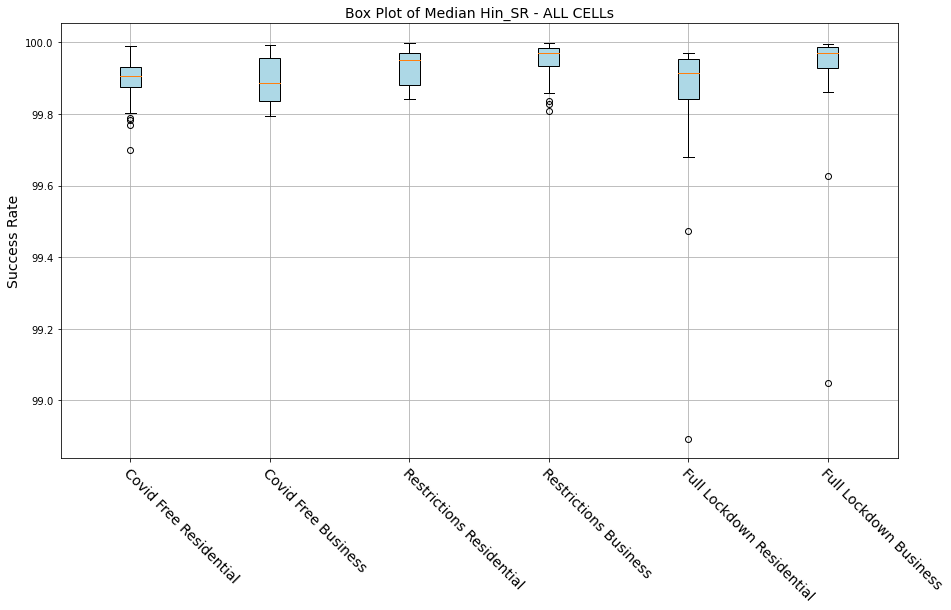


--------- Covid Free Residential Hin_SR ---------
Median value: 99.91
Average value: 99.90
Standard deviation: 0.06
--------- Covid Free Business Hin_SR ---------
Median value: 99.89
Average value: 99.89
Standard deviation: 0.06
--------- Restrictions Residential Hin_SR ---------
Median value: 99.95
Average value: 99.93
Standard deviation: 0.05
--------- Restrictions Business Hin_SR ---------
Median value: 99.97
Average value: 99.95
Standard deviation: 0.06
--------- Full Lockdown Residential Hin_SR ---------
Median value: 99.91
Average value: 99.83
Standard deviation: 0.24
--------- Full Lockdown Business Hin_SR ---------
Median value: 99.97
Average value: 99.90
Standard deviation: 0.20
>>>------ Covid Free Residential Hin_SR Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Covid Free Business ]: -0.02%
Average difference between [ Covid Free Residential ] and [ Covid Free Business ]: -0.01%
Std. deviation difference between [ Covid Free Residential ] an

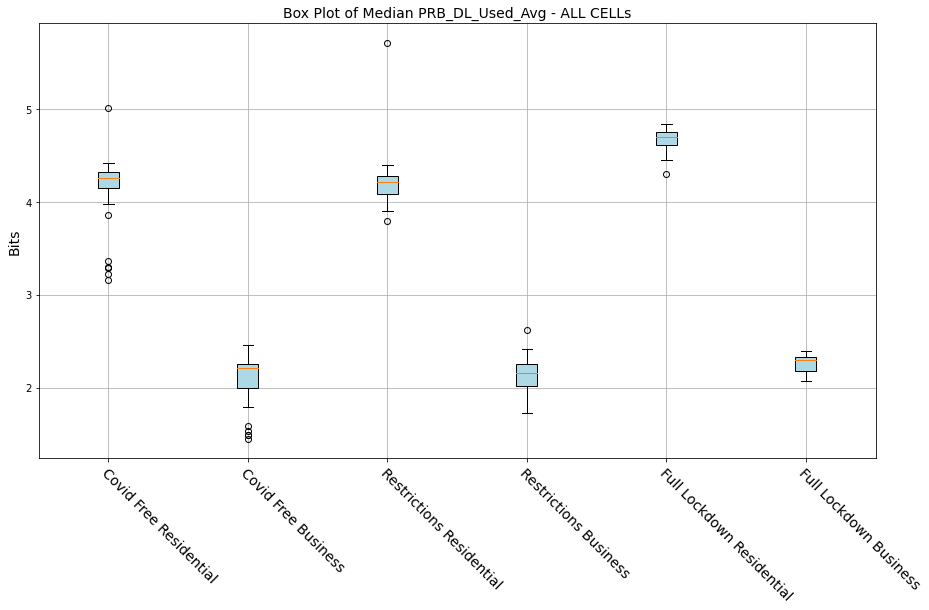


--------- Covid Free Residential PRB_DL_Used_Avg ---------
Median value: 4.25
Average value: 4.15
Standard deviation: 0.34
--------- Covid Free Business PRB_DL_Used_Avg ---------
Median value: 2.21
Average value: 2.09
Standard deviation: 0.24
--------- Restrictions Residential PRB_DL_Used_Avg ---------
Median value: 4.21
Average value: 4.24
Standard deviation: 0.34
--------- Restrictions Business PRB_DL_Used_Avg ---------
Median value: 2.15
Average value: 2.14
Standard deviation: 0.21
--------- Full Lockdown Residential PRB_DL_Used_Avg ---------
Median value: 4.70
Average value: 4.67
Standard deviation: 0.13
--------- Full Lockdown Business PRB_DL_Used_Avg ---------
Median value: 2.30
Average value: 2.26
Standard deviation: 0.09
>>>------ Covid Free Residential PRB_DL_Used_Avg Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Covid Free Business ]: -48.14%
Average difference between [ Covid Free Residential ] and [ Covid Free Business ]: -49.61%
Std. devia

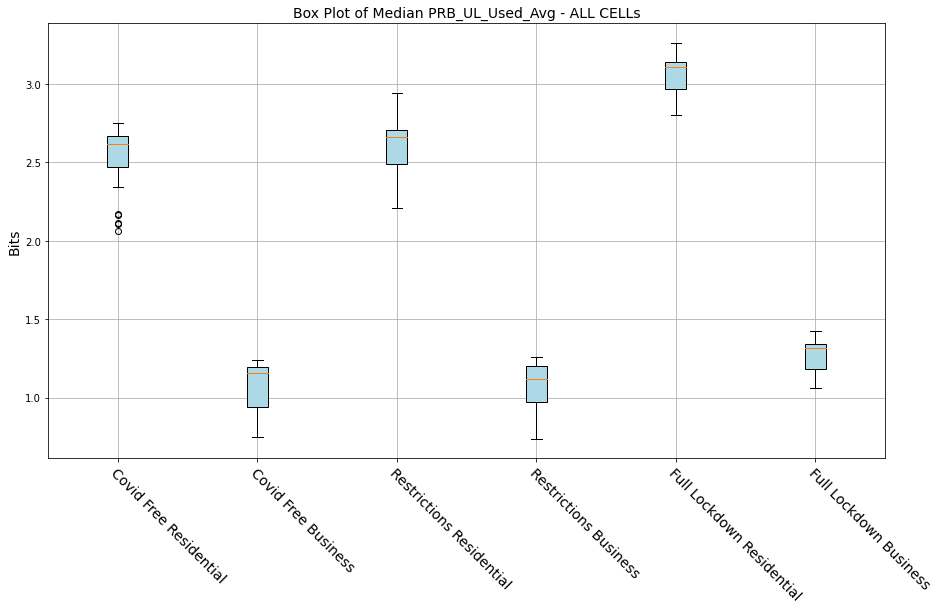


--------- Covid Free Residential PRB_UL_Used_Avg ---------
Median value: 2.62
Average value: 2.54
Standard deviation: 0.18
--------- Covid Free Business PRB_UL_Used_Avg ---------
Median value: 1.16
Average value: 1.06
Standard deviation: 0.16
--------- Restrictions Residential PRB_UL_Used_Avg ---------
Median value: 2.66
Average value: 2.60
Standard deviation: 0.19
--------- Restrictions Business PRB_UL_Used_Avg ---------
Median value: 1.12
Average value: 1.06
Standard deviation: 0.16
--------- Full Lockdown Residential PRB_UL_Used_Avg ---------
Median value: 3.11
Average value: 3.06
Standard deviation: 0.13
--------- Full Lockdown Business PRB_UL_Used_Avg ---------
Median value: 1.32
Average value: 1.27
Standard deviation: 0.11
>>>------ Covid Free Residential PRB_UL_Used_Avg Variation ------<<<
Median difference between [ Covid Free Residential ] and [ Covid Free Business ]: -55.85%
Average difference between [ Covid Free Residential ] and [ Covid Free Business ]: -58.14%
Std. devia

In [27]:
periods = [covid_free_residential, covid_free_business, restrictions_residential, restrictions_business, full_lockdown_residential, full_lockdown_business]
periods_lables = ['Covid Free Residential', 'Covid Free Business', 'Restrictions Residential', 'Restrictions Business', 'Full Lockdown Residential', 'Full Lockdown Business']
plot_stats(periods, periods_lables)